# Find non-advective edges in bathymetry

See https://github.com/OceansAus/access-om2/issues/99
and https://github.com/COSIMA/access-om2/issues/210

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import netCDF4 as nc
import IPython.display

In [14]:
# file = '/g/data3/hh5/tmp/cosima/bathymetry/topog_latest.nc'

# see https://github.com/OceansAus/access-om2/issues/99
# badbathyfile = '/g/data3/hh5/tmp/cosima/bathymetry/topog_12_10_17_yenesei.nc'
# bathyfile = '/g/data3/hh5/tmp/cosima/bathymetry/topog_12_06_2018.baffin.nc'
# bathyfile = '/g/data3/hh5/tmp/cosima/bathymetry/topog_05_09_2018_1m_partial.nc'
# bathyfile = '/g/data3/hh5/tmp/cosima/bathymetry/topog_18_12_2018_min_dyt.nc'

# bathyfile = '/g/data/hh5/tmp/cosima/bathymetry/topog_18_12_2018_min_dyt.nc'

bathyfile = '/g/data/ik11/inputs/access-om2/input_20200530/mom_1deg/topog.nc'

bathyfile = '/g/data/ik11/inputs/access-om2/input_20200530/mom_025deg/topog.nc'

# bathyfile = '/g/data/ik11/inputs/access-om2/input_20200530/mom_01deg/topog.nc'

bathyfile = '/scratch/v45/aek156/bathymetry/tools/1_deg_test/topog_new_deseas_partialcell_mindepth_masked_fixnonadvective.nc'

# bathyfile = '/scratch/v45/aek156/bathymetry/tools/025_deg_test/topog_new_deseas_partialcell_mindepth_masked_fixnonadvective.nc'

# maskfile = '/scratch/v45/aek156/bathymetry/tools/025_deg_test/ocean_mask.nc'



depth = nc.Dataset(bathyfile).variables['depth'][:,:]

# mask = nc.Dataset(maskfile).variables['mask'][:,:]

jsize,isize = np.shape(depth)

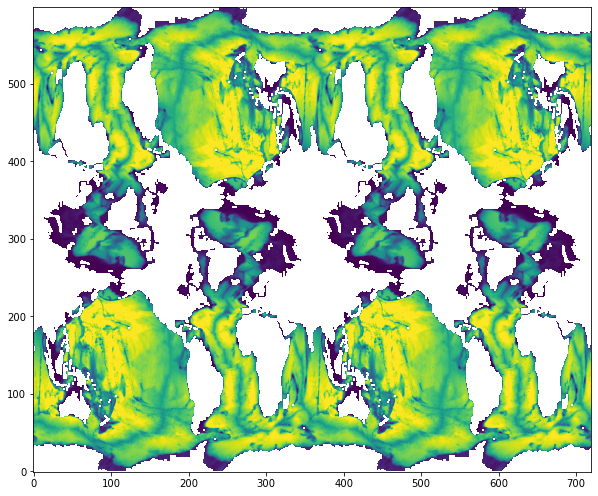

In [15]:
# make tiled version for plotting across joins
depthtiled = np.zeros((2*jsize,2*isize))
depthtiled[:jsize,:isize] = depth
# add flipped copy along tripole seam
depthtiled[jsize:, 0:int(isize/2)] = np.flip(np.flip(depth[:jsize,int(isize/2):isize],0),1)
depthtiled[jsize:, int(isize/2):isize] = np.flip(np.flip(depth[:jsize,0:int(isize/2)],0),1)
# add zonal repeat
depthtiled[:, isize:] = depthtiled[:, :isize] 
# velzero[-1,int(isize/2):-1] = np.flip(velzero[-2,0:int(isize/2)], 0)
depthtiled = np.ma.masked_less_equal(depthtiled, 0)

plt.figure(figsize=(10,10))
plt.imshow(depthtiled, origin='lower')

In [16]:
np.ma.is_masked(depth)

True

In [17]:
depth.min()

11.80575

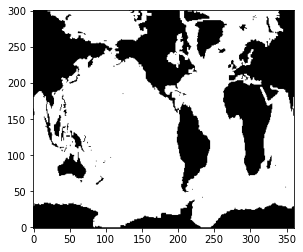

In [18]:
landmask = np.zeros((jsize+1,isize+1),dtype=int)
if not np.ma.is_masked(depth):
    depth = np.ma.masked_less_equal(depth, 0)
landmask[:-1,:-1] = np.ma.getmask(depth).astype(int) 
# add copied points along tripole seam
landmask[-1, 0:int(isize/2)] = np.flip(landmask[-2,int(isize/2):-1],0)
landmask[-1,int(isize/2):-1] = np.flip(landmask[-2,0:int(isize/2)], 0)
# add LH edge to RH edge
landmask[:,-1] = landmask[:,0]
# plt.figure(figsize=(15,15))
# plt.imshow(landmask[-3:,:], origin='lower', cmap=cm.binary,aspect=40)
# plt.figure(figsize=(15,15))
# plt.imshow(landmask[:,-3:], origin='lower', cmap=cm.binary,aspect=.02)
plt.figure
plt.imshow(landmask, origin='lower', cmap=cm.binary)

In [19]:
velzero = np.zeros(np.shape(landmask),dtype=bool)  # whether u,v are zero on NE corner of cell
velzero[:-1,:-1] = landmask[:-1,:-1]+landmask[1:,:-1]+landmask[:-1,1:]+landmask[1:,1:] > 0 # true if velocity point touches land mask
# add copied points along tripole seam
velzero[-1, 0:int(isize/2)] = np.flip(velzero[-2,int(isize/2):-1],0)
velzero[-1,int(isize/2):-1] = np.flip(velzero[-2,0:int(isize/2)], 0)
# add LH edge to RH edge
velzero[:,-1] = velzero[:,0]

# plt.imshow(velzero, origin='lower', cmap=cm.binary)

In [20]:
# now find ocean cells that have zero flux through either open northern or open eastern edges
# see fig 9.4 in Griffies2012a-mom-elements-5-updated.pdf
noadvN = np.zeros(np.shape(landmask),dtype=bool)
noadvE = np.zeros(np.shape(landmask),dtype=bool)

noadvN[:,1:] = np.logical_and(velzero[:,1:], velzero[:,:-1])  # no flux through northern edge
noadvN[:,0 ] = noadvN[:,-1]  # copy RH edge to LH edge
noadvN[:-1,:] = np.logical_and(noadvN[:-1,:], np.logical_not(landmask[1:,:]))  # only consider open northern edges

noadvE[1:,:] = np.logical_and(velzero[1:,:], velzero[:-1,:])  # no flux through eastern edge
noadvE[0 ,:] = velzero[1,:]  # assumes no flow along southern edge
noadvE[:,:-1] = np.logical_and(noadvE[:,:-1], np.logical_not(landmask[:,1:]))  # only consider open eastern edges

noadv_edge = np.logical_or(noadvN[:-1,:-1], noadvE[:-1,:-1])
noadv_edge = np.logical_and(noadv_edge, np.logical_not(landmask[:-1,:-1]))  # only consider ocean points

# find cells with no advection through any edge
noadv_cell = np.zeros(np.shape(landmask),dtype=bool)
noadv_cell[1:,1:] = np.logical_and(np.logical_and(np.logical_and(velzero[1:,1:], velzero[1:,:-1]), velzero[:-1,1:]), velzero[:-1,:-1])
noadv_cell[0,1:] = np.logical_and(velzero[0,1:], velzero[0,:-1]) # assumes no flow along southern edge
noadv_cell[:,0] = noadv_cell[:,-1]  # copy RH edge to LH edge
noadv_cell = noadv_cell[:-1,:-1]
noadv_cell = np.logical_and(noadv_cell, np.logical_not(landmask[:-1,:-1]))  # only consider ocean points

In [21]:
np.count_nonzero(noadv_cell)

0

In [22]:
np.count_nonzero(noadv_edge)

6

In [24]:
margin = 20
jj,ii=np.nonzero(noadv_cell)
print ('cells with no advective edges: '+repr(list(zip(ii+1,jj+1))))
for k in range(len(ii)):
    i = ii[k]
    j = jj[k]
    plt.figure(figsize=(10,10))
    plt.imshow(depthtiled, vmin=0, vmax=200, origin='lower')
    plt.colorbar()
    plt.scatter(i,j, facecolors='none', edgecolors='r')
    plt.xlim(i-margin,i+margin)
    plt.ylim(j-margin,j+margin)
    plt.title('Non-advective cell: MOM index '+str(i+1)+', '+str(j+1)+'\n'+bathyfile)
    plt.xlabel('i (indexed from 0)')
    plt.ylabel('j (indexed from 0)')
    figfname = 'non-advective/non_advective_cell'+bathyfile.replace('/','_').replace('.','_')+'_'+str(i+1)+'_'+str(j+1)+'.png'
#     plt.savefig(figfname,dpi=100, bbox_inches="tight")

#     plt.figure(figsize=(10,10))
#     plt.imshow(mask, origin='lower')
#     plt.colorbar()
#     plt.scatter(i,j, facecolors='none', edgecolors='r')
#     plt.xlim(i-margin,i+margin)
#     plt.ylim(j-margin,j+margin)



cells with no advective edges: []


cells with a non-advective edge: [(99, 92), (201, 227), (115, 235), (70, 269), (308, 291), (307, 293)]


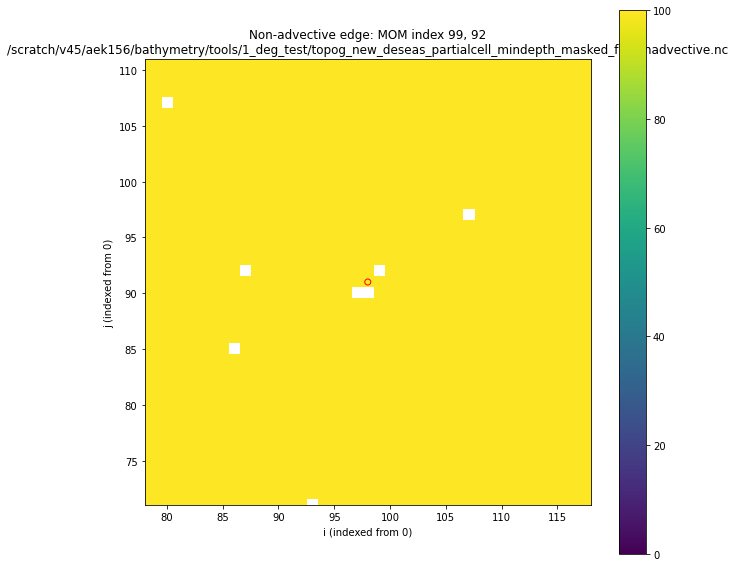

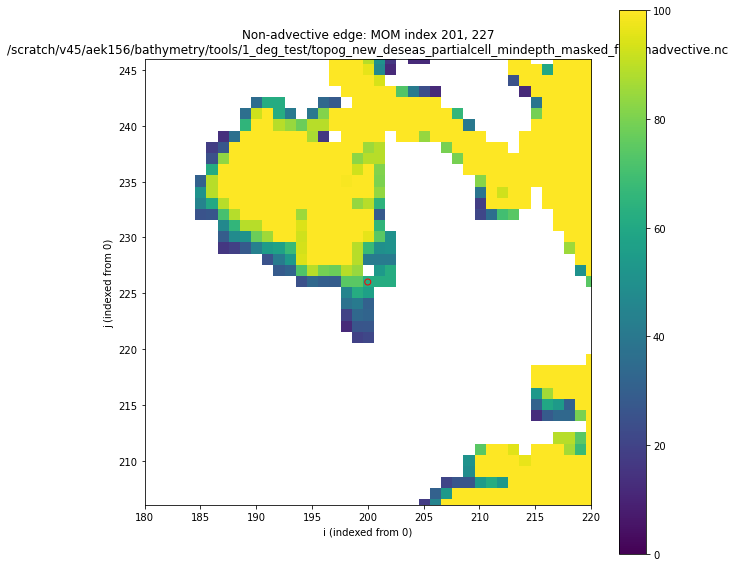

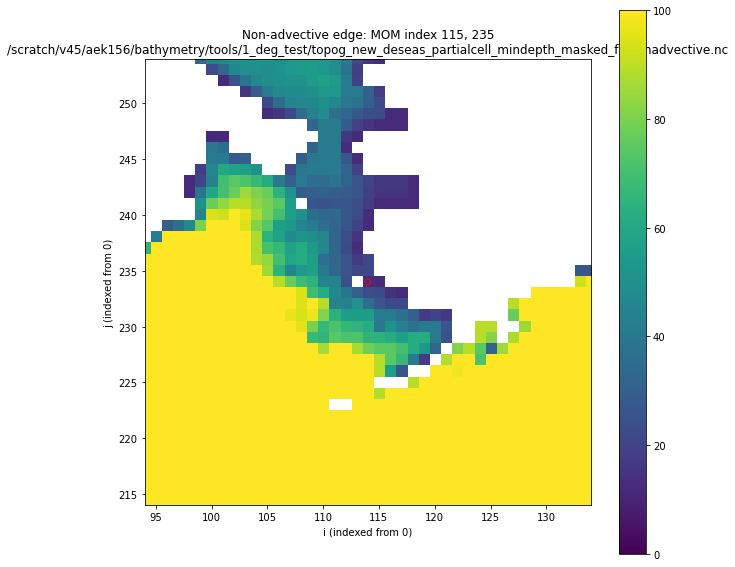

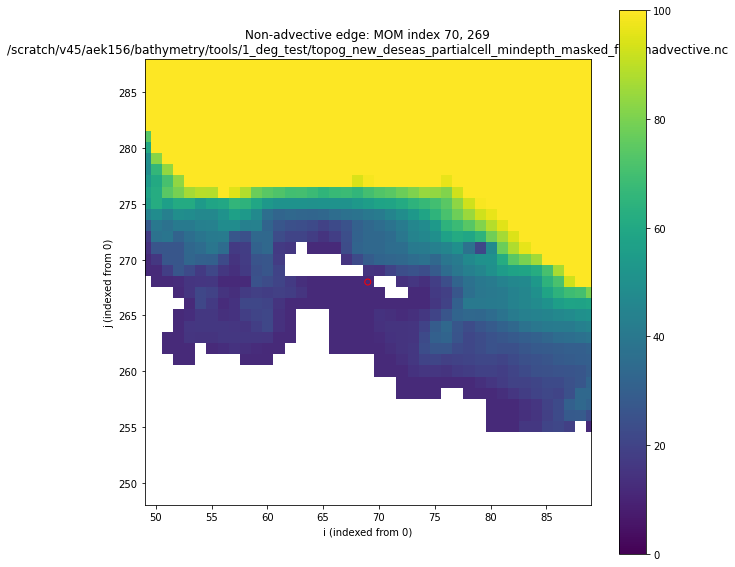

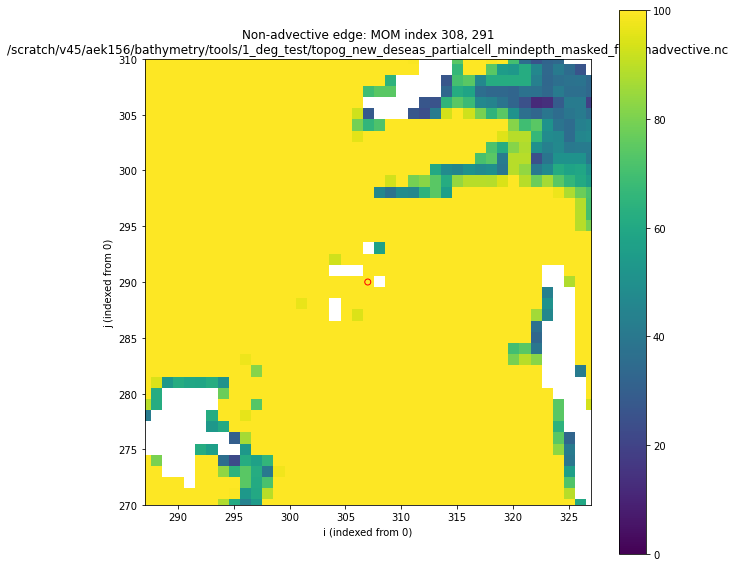

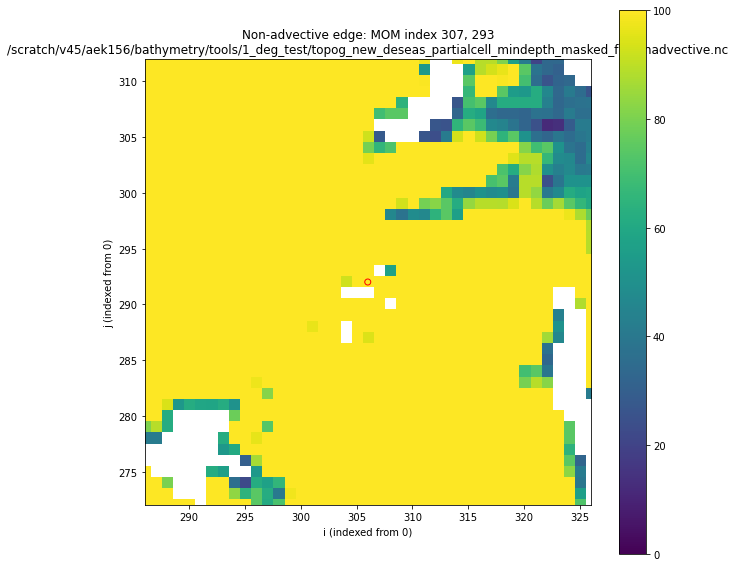

In [25]:
margin = 20
jj,ii=np.nonzero(noadv_edge)
print ('cells with a non-advective edge: '+repr(list(zip(ii+1,jj+1))))
for k in range(len(ii)):
    i = ii[k]
    j = jj[k]
    plt.figure(figsize=(10,10))
    plt.imshow(depthtiled, vmin=0, vmax=100, origin='lower')
    plt.colorbar()
    plt.scatter(i,j, facecolors='none', edgecolors='r')
    plt.xlim(i-margin,i+margin)
    plt.ylim(j-margin,j+margin)
    plt.title('Non-advective edge: MOM index '+str(i+1)+', '+str(j+1)+'\n'+bathyfile)
    plt.xlabel('i (indexed from 0)')
    plt.ylabel('j (indexed from 0)')
    figfname = 'non-advective/non_advective_edge'+bathyfile.replace('/','_').replace('.','_')+'_'+str(i+1)+'_'+str(j+1)+'.png'
#     plt.savefig(figfname,dpi=100, bbox_inches="tight")

## look at gebco bathymetry around a given point
from `bathymetry-closeup-baffin.ipynb`

In [102]:
file2 = '/g/data/ik11/inputs/access-om2/input_20200530/mom_025deg/ocean_hgrid.nc'
data2 = nc.Dataset(file2)
lons = data2.variables['x'][::2,::2]
lats = data2.variables['y'][::2,::2]


In [101]:
# this is really slow!
gebcofile = '/g/data3/hh5/tmp/cosima/bathymetry/gebco.nc'
gebcodata = nc.Dataset(gebcofile)
gebcodepth = -gebcodata.variables['height'][:,:]
gebcolat = gebcodata.variables['lat'][:]
gebcolon = gebcodata.variables['lon'][:]

In [103]:
i,j = 893, 739

jgebco = (np.abs(gebcolat - lats[j,i])).argmin()
igebco = (np.abs(gebcolon - lons[j,i])).argmin()

jgebcoa = (np.abs(gebcolat - lats[j-margin,i-margin])).argmin()
igebcoa = (np.abs(gebcolon - lons[j-margin,i-margin])).argmin()

jgebcob = (np.abs(gebcolat - lats[j+margin,i+margin])).argmin()
igebcob = (np.abs(gebcolon - lons[j+margin,i+margin])).argmin()

igebcomin = min(igebcoa, igebcob)
jgebcomin = min(jgebcoa, jgebcob)
igebcomax = max(igebcoa, igebcob)
jgebcomax = max(jgebcoa, jgebcob)

In [104]:
gebcodepthplot = gebcodepth[jgebcomin:jgebcomax,igebcomin:igebcomax]
# gebcodepthplot[gebcodepthplot<0.0] = np.float64(np.nan)

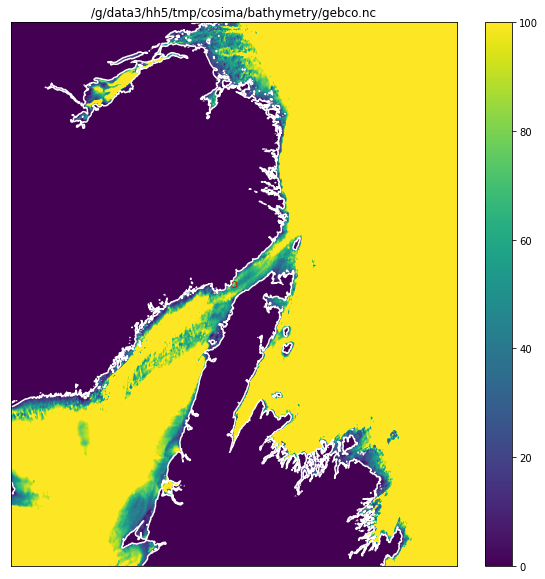

In [106]:
plt.figure(figsize=(10,10))
plt.imshow(gebcodepthplot, vmin=0, vmax=100, origin='lower',aspect='auto')
plt.colorbar()
plt.contour(gebcodepthplot,[0],colors='w')
plt.scatter(igebco-igebcomin,jgebco-jgebcomin, facecolors='none', edgecolors='r')
plt.title(gebcofile)
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([]);
# plt.xlabel('i')
# plt.ylabel('j')
figfname = 'gebco'+'_'+str(i+1)+'_'+str(j+1)+'.png'
plt.savefig(figfname,dpi=100, bbox_inches="tight")

## cross-check
These are points identified in `/g/data/ik11/inputs/access-om2/input_20200530/mom_025deg/topog.nc` by Russ' code - see https://github.com/COSIMA/access-om2/issues/210

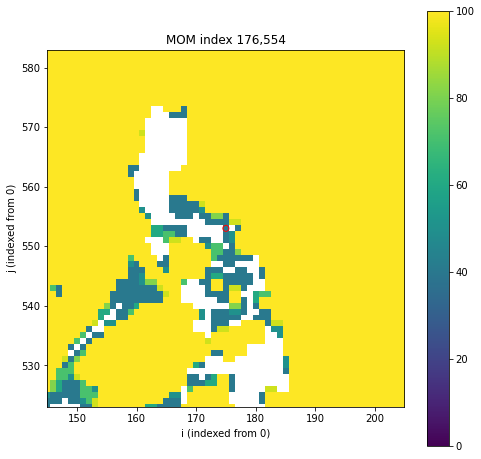

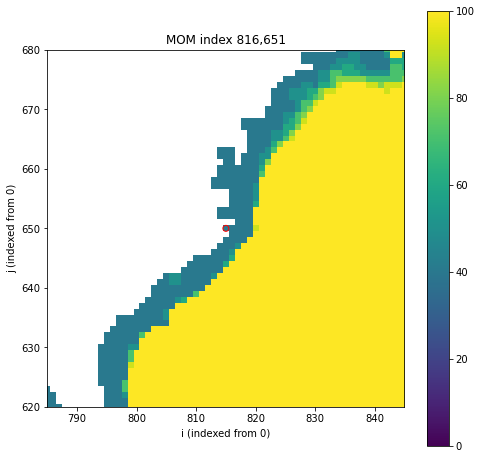

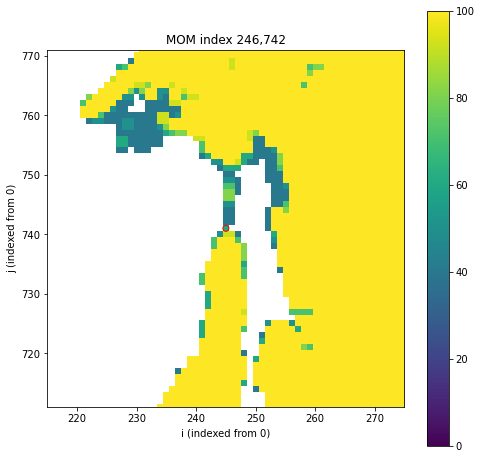

In [94]:
margin = 30
indices = [ (176, 554), (816, 651), (246, 742) ]
for i,j in indices:
    i -= 1
    j -= 1
    plt.figure(figsize=(8,8))
    plt.imshow(depthtiled, vmin=0, vmax=100, origin='lower')
    plt.colorbar()
    plt.scatter(i,j, facecolors='none', edgecolors='r')
    plt.xlim(i-margin,i+margin)
    plt.ylim(j-margin,j+margin)
    plt.title(bathyfile)
    plt.title('MOM index '+str(i+1)+','+str(j+1))
    plt.xlabel('i (indexed from 0)')
    plt.ylabel('j (indexed from 0)')